# NBA Winner Classifier

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.data as data
import model.dataset.season_game as sg
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set(style="whitegrid", palette="husl")

### Utils functions

In [3]:
def del_exp_result(exp_name):
    for idx, res in enumerate(list(utils_exp.exp_results)):
        if res['exp_name'] == exp_name:
            del utils_exp.exp_results[idx]

In [4]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [5]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.pointplot(data=results_df,
              kind="point", x="season_test", y="balanced_accuracy", hue="model"
              )
    a.set_title(
        f"{experiment_name}-balanced_accuracy")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [6]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [7]:
metrics = ['precision', 'balanced_accuracy', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='roc_auc'):
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std']]
    return ba_df[ba_df.exp_name == exp_name].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [8]:
season_games = sg.load_season_games_dataset()

## Dataset


In [20]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [9]:
df = season_games[season_games.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

## Experiments

### Setup

In [10]:
exp_prefix = "clf_"
exp_group_name = "clf_experiments"
results_total = []
utils_exp.exp_results = []
TARGET = "HOME_WINS"
exp_X_columns = model_config.X_COLS
exp_y_columns = model_config.Y_CLF_COL


models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

#utils_exp.exp_results = utils.deserialize_object(exp_group_name)

### Experiment using 1 season

In [15]:
experiment_name = f"{exp_prefix}1_season"
#del_exp_result(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_1_season
Done


,exp_name,model,roc_auc_mean,roc_auc_std
0,clf_1_season,LR,0.780261,0.010426
3,clf_1_season,SVM,0.777122,0.011170
4,clf_1_season,RF,0.759034,0.013917
5,clf_1_season,XGB,0.754009,0.013419
6,clf_1_season,LGB,0.752695,0.011817
1,clf_1_season,KNN,0.746522,0.019632
2,clf_1_season,DT,0.687936,0.020562


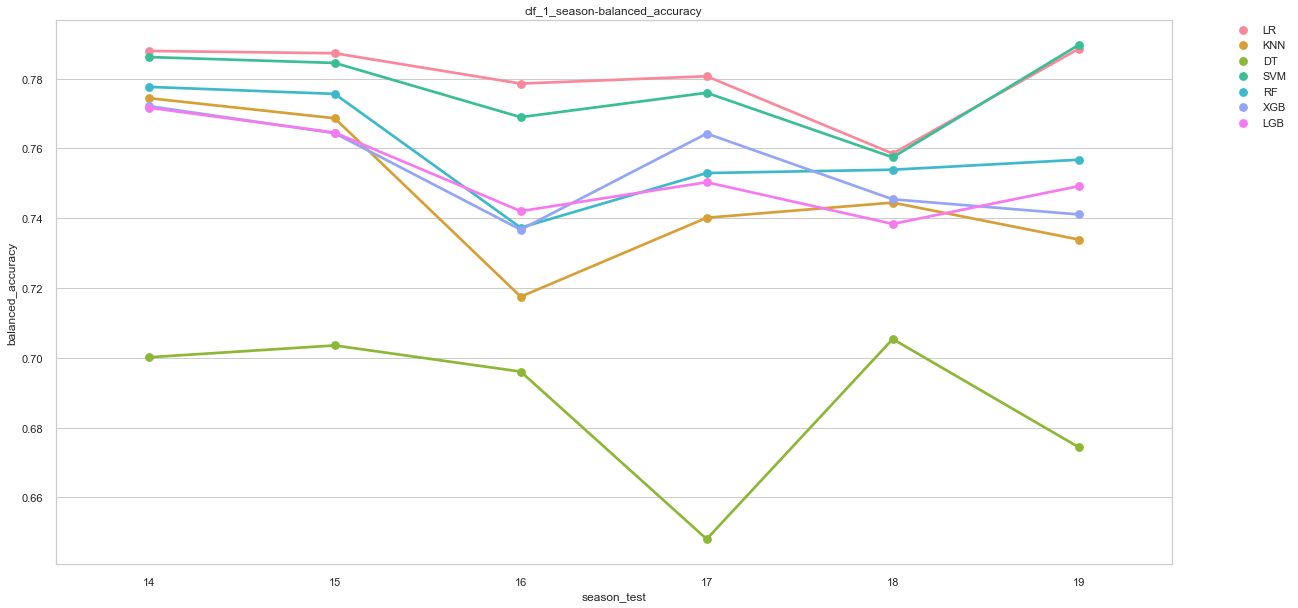

In [16]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

### Experiment using StandardScaler

In [17]:
experiment_name = f"{exp_prefix}scaled_data"

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_scaled_data
Done


,exp_name,model,roc_auc_mean,roc_auc_std
7,clf_scaled_data,LR,0.778341,0.008131
10,clf_scaled_data,SVM,0.772985,0.010027
11,clf_scaled_data,RF,0.758934,0.014034
12,clf_scaled_data,XGB,0.753640,0.013484
13,clf_scaled_data,LGB,0.752528,0.010076
8,clf_scaled_data,KNN,0.744896,0.013435
9,clf_scaled_data,DT,0.687181,0.019818


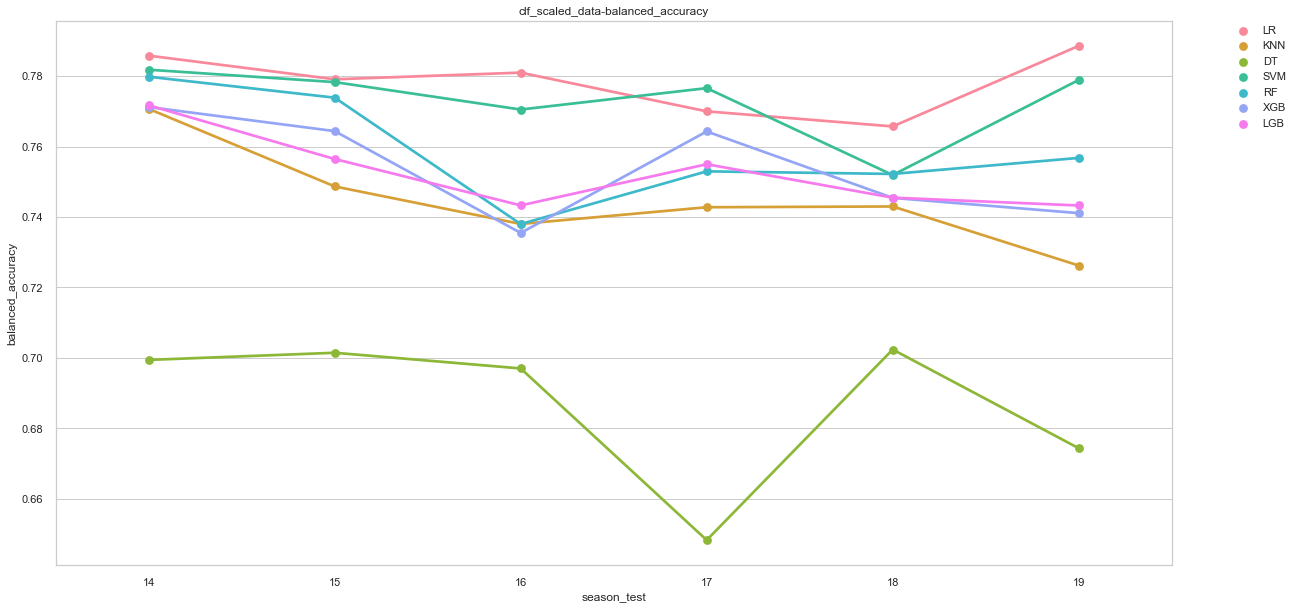

In [18]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment using MinMaxScaler

In [19]:
experiment_name = f"{exp_prefix}minmax_data"

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_minmax_data
Done


,exp_name,model,roc_auc_mean,roc_auc_std
17,clf_minmax_data,SVM,0.777829,0.006862
14,clf_minmax_data,LR,0.777770,0.005737
18,clf_minmax_data,RF,0.760074,0.013776
15,clf_minmax_data,KNN,0.758201,0.010619
19,clf_minmax_data,XGB,0.753846,0.013632
20,clf_minmax_data,LGB,0.750258,0.011822
16,clf_minmax_data,DT,0.688056,0.020985


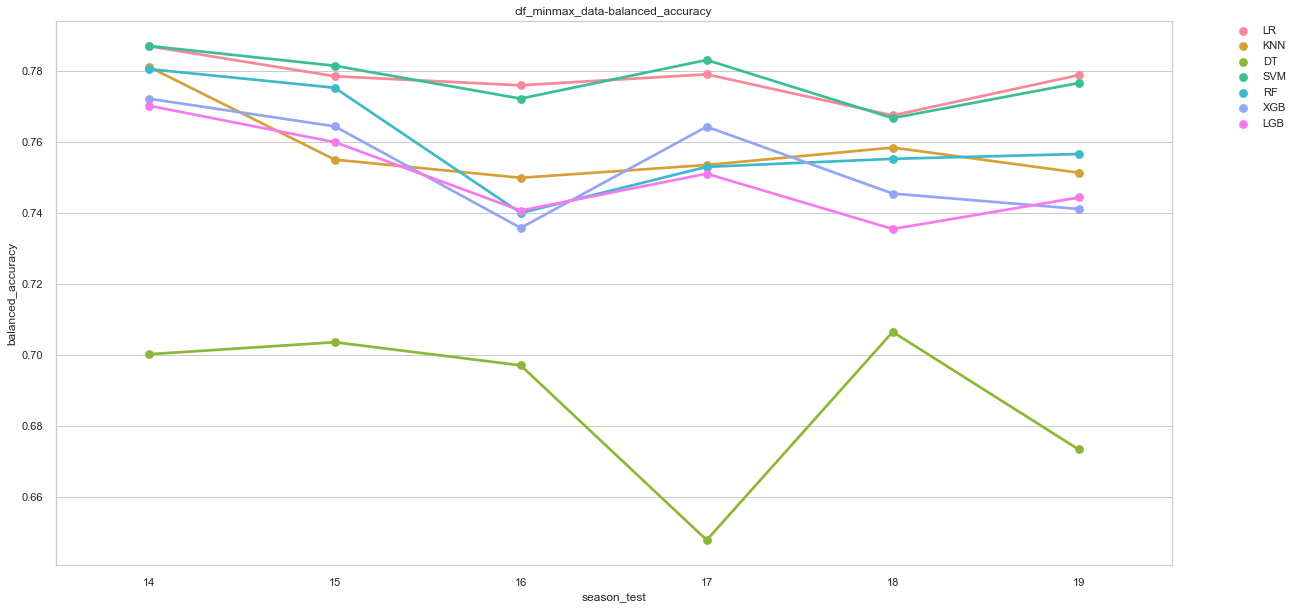

In [20]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment: train: 2s; test: 1s

In [21]:
experiment_name = f"{exp_prefix}2_seasons"

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons
Done


,exp_name,model,roc_auc_mean,roc_auc_std
21,clf_2_seasons,LR,0.782677,0.008121
24,clf_2_seasons,SVM,0.781626,0.005909
25,clf_2_seasons,RF,0.766163,0.006284
27,clf_2_seasons,LGB,0.758220,0.006782
26,clf_2_seasons,XGB,0.758131,0.008643
22,clf_2_seasons,KNN,0.748068,0.014390
23,clf_2_seasons,DT,0.687840,0.013786


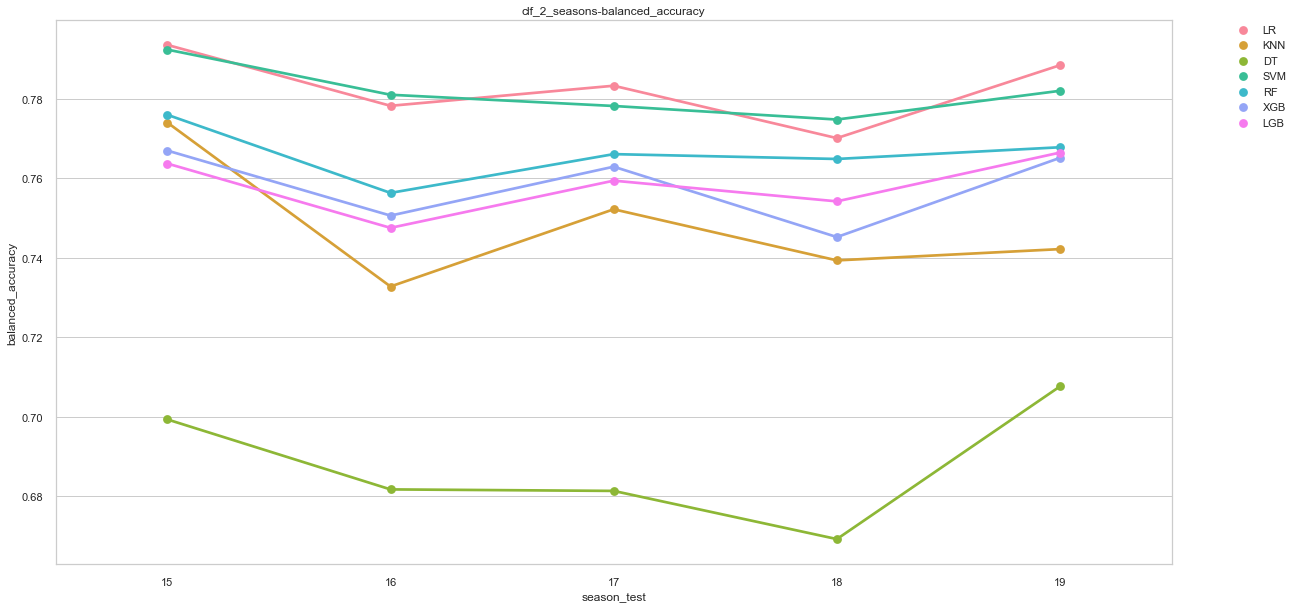

In [22]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment: train: 3s; test: 1s

In [23]:
experiment_name = f"{exp_prefix}3_seasons"

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3_seasons
Done


,exp_name,model,roc_auc_mean,roc_auc_std
28,clf_3_seasons,LR,0.783168,0.003503
31,clf_3_seasons,SVM,0.782053,0.005573
32,clf_3_seasons,RF,0.762544,0.007694
34,clf_3_seasons,LGB,0.760184,0.007527
33,clf_3_seasons,XGB,0.759003,0.008412
29,clf_3_seasons,KNN,0.742285,0.004976
30,clf_3_seasons,DT,0.696434,0.017371


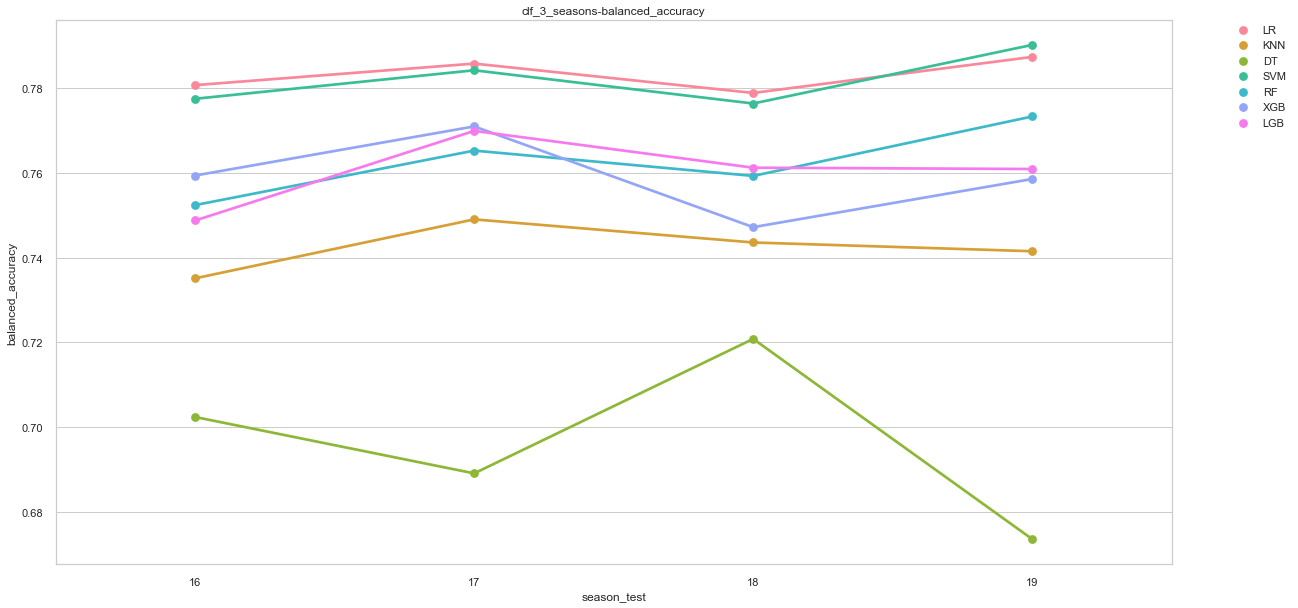

In [24]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment train: 3q ; test: 1q

In [25]:
experiment_name = f"{exp_prefix}3q_1q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
35,clf_3q_1q,LR,0.767468,0.035726
38,clf_3q_1q,SVM,0.764719,0.034466
39,clf_3q_1q,RF,0.756327,0.023824
41,clf_3q_1q,LGB,0.750759,0.022214
40,clf_3q_1q,XGB,0.746722,0.019767
36,clf_3q_1q,KNN,0.739851,0.021994
37,clf_3q_1q,DT,0.683942,0.030592


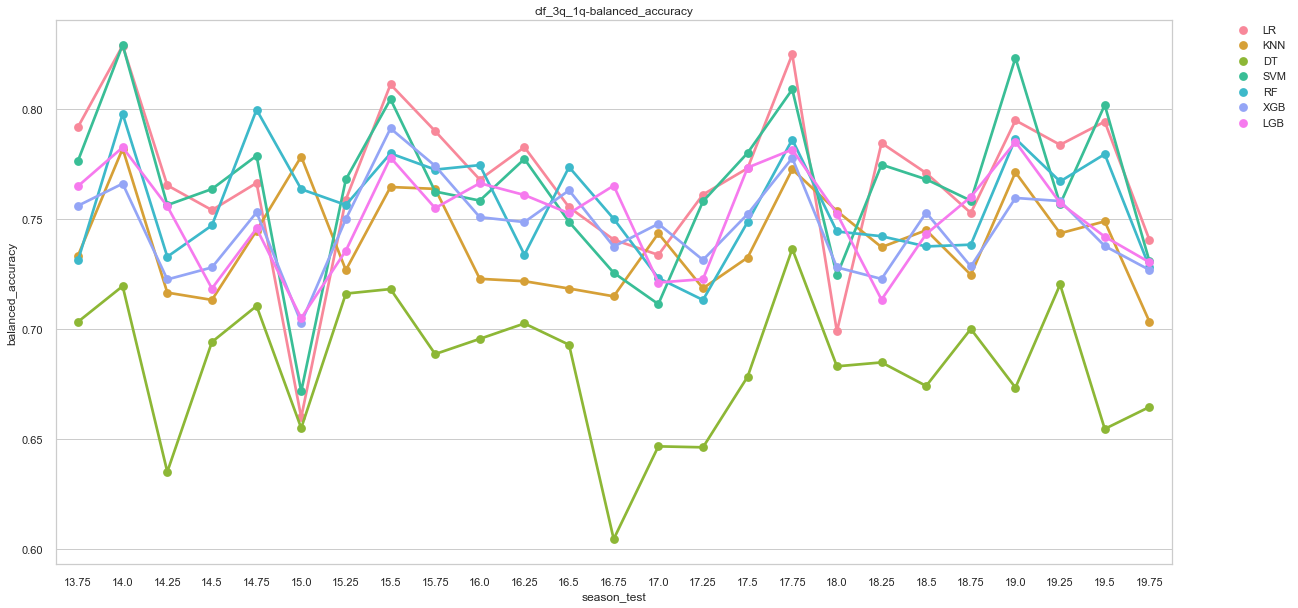

In [26]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment train: 4q ; test: 2q

In [27]:
experiment_name = f"{exp_prefix}4q_2q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
42,clf_4q_2q,LR,0.778277,0.017891
45,clf_4q_2q,SVM,0.777408,0.018717
46,clf_4q_2q,RF,0.759072,0.015400
47,clf_4q_2q,XGB,0.753470,0.017446
48,clf_4q_2q,LGB,0.752734,0.016580
43,clf_4q_2q,KNN,0.746689,0.017449
44,clf_4q_2q,DT,0.686730,0.021938


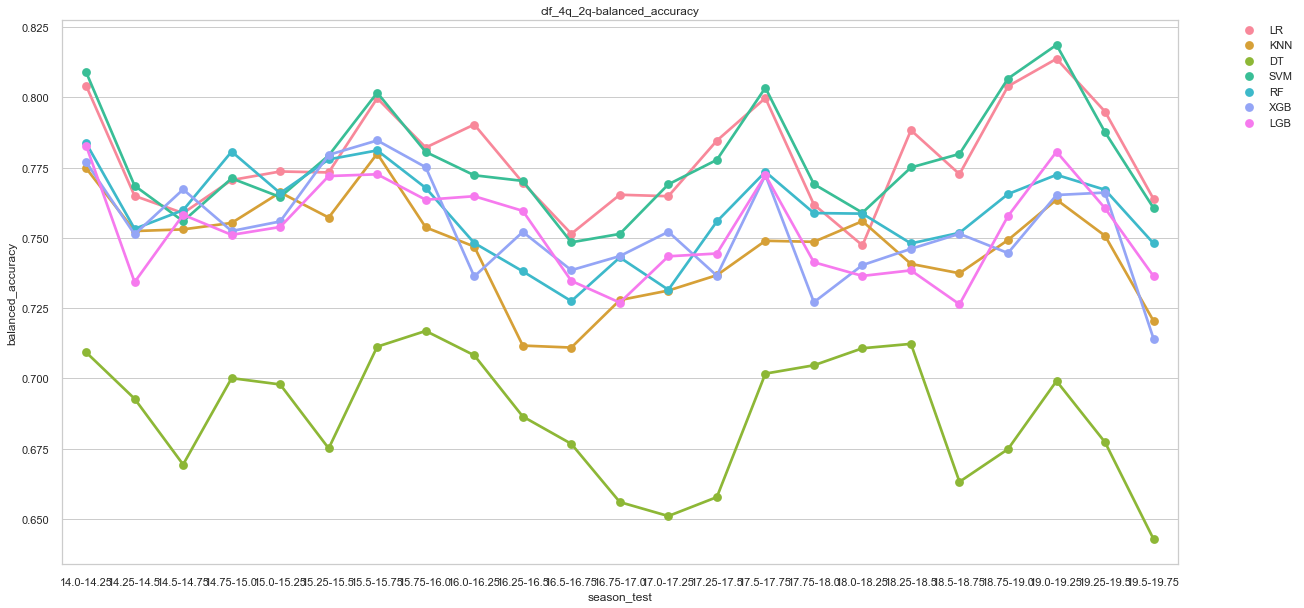

In [28]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [29]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_r1q_2q_1q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
49,clf_r1q_2q_1q,LR,0.769442,0.025525
52,clf_r1q_2q_1q,SVM,0.766275,0.024159
53,clf_r1q_2q_1q,RF,0.757108,0.020682
55,clf_r1q_2q_1q,LGB,0.750440,0.018532
54,clf_r1q_2q_1q,XGB,0.748461,0.019934
50,clf_r1q_2q_1q,KNN,0.739513,0.018492
51,clf_r1q_2q_1q,DT,0.682447,0.029494


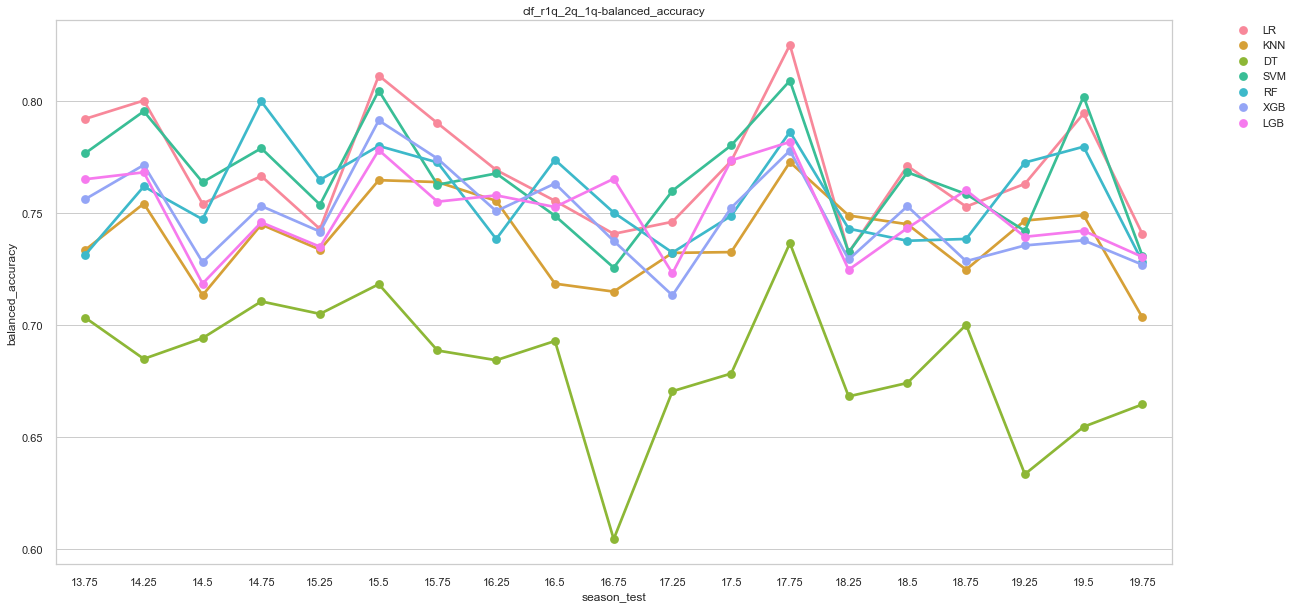

In [30]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

### Experiments comparison

In [35]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [36]:
utils_exp.exp_results = utils.deserialize_object(exp_group_name)
exp_df = get_results_df()

In [37]:
ba_df = exp_df[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]

In [38]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [39]:
ba_df.sort_values(
    by=["balanced_accuracy_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
0,clf_3_seasons,LR,0.783168,0.003503
1,clf_2_seasons,LR,0.782677,0.008121
2,clf_3_seasons,SVM,0.782053,0.005573
3,clf_2_seasons,SVM,0.781626,0.005909
4,clf_1_season,LR,0.780261,0.010426
5,clf_scaled_data,LR,0.778341,0.008131


### Plot experiment results

In [34]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

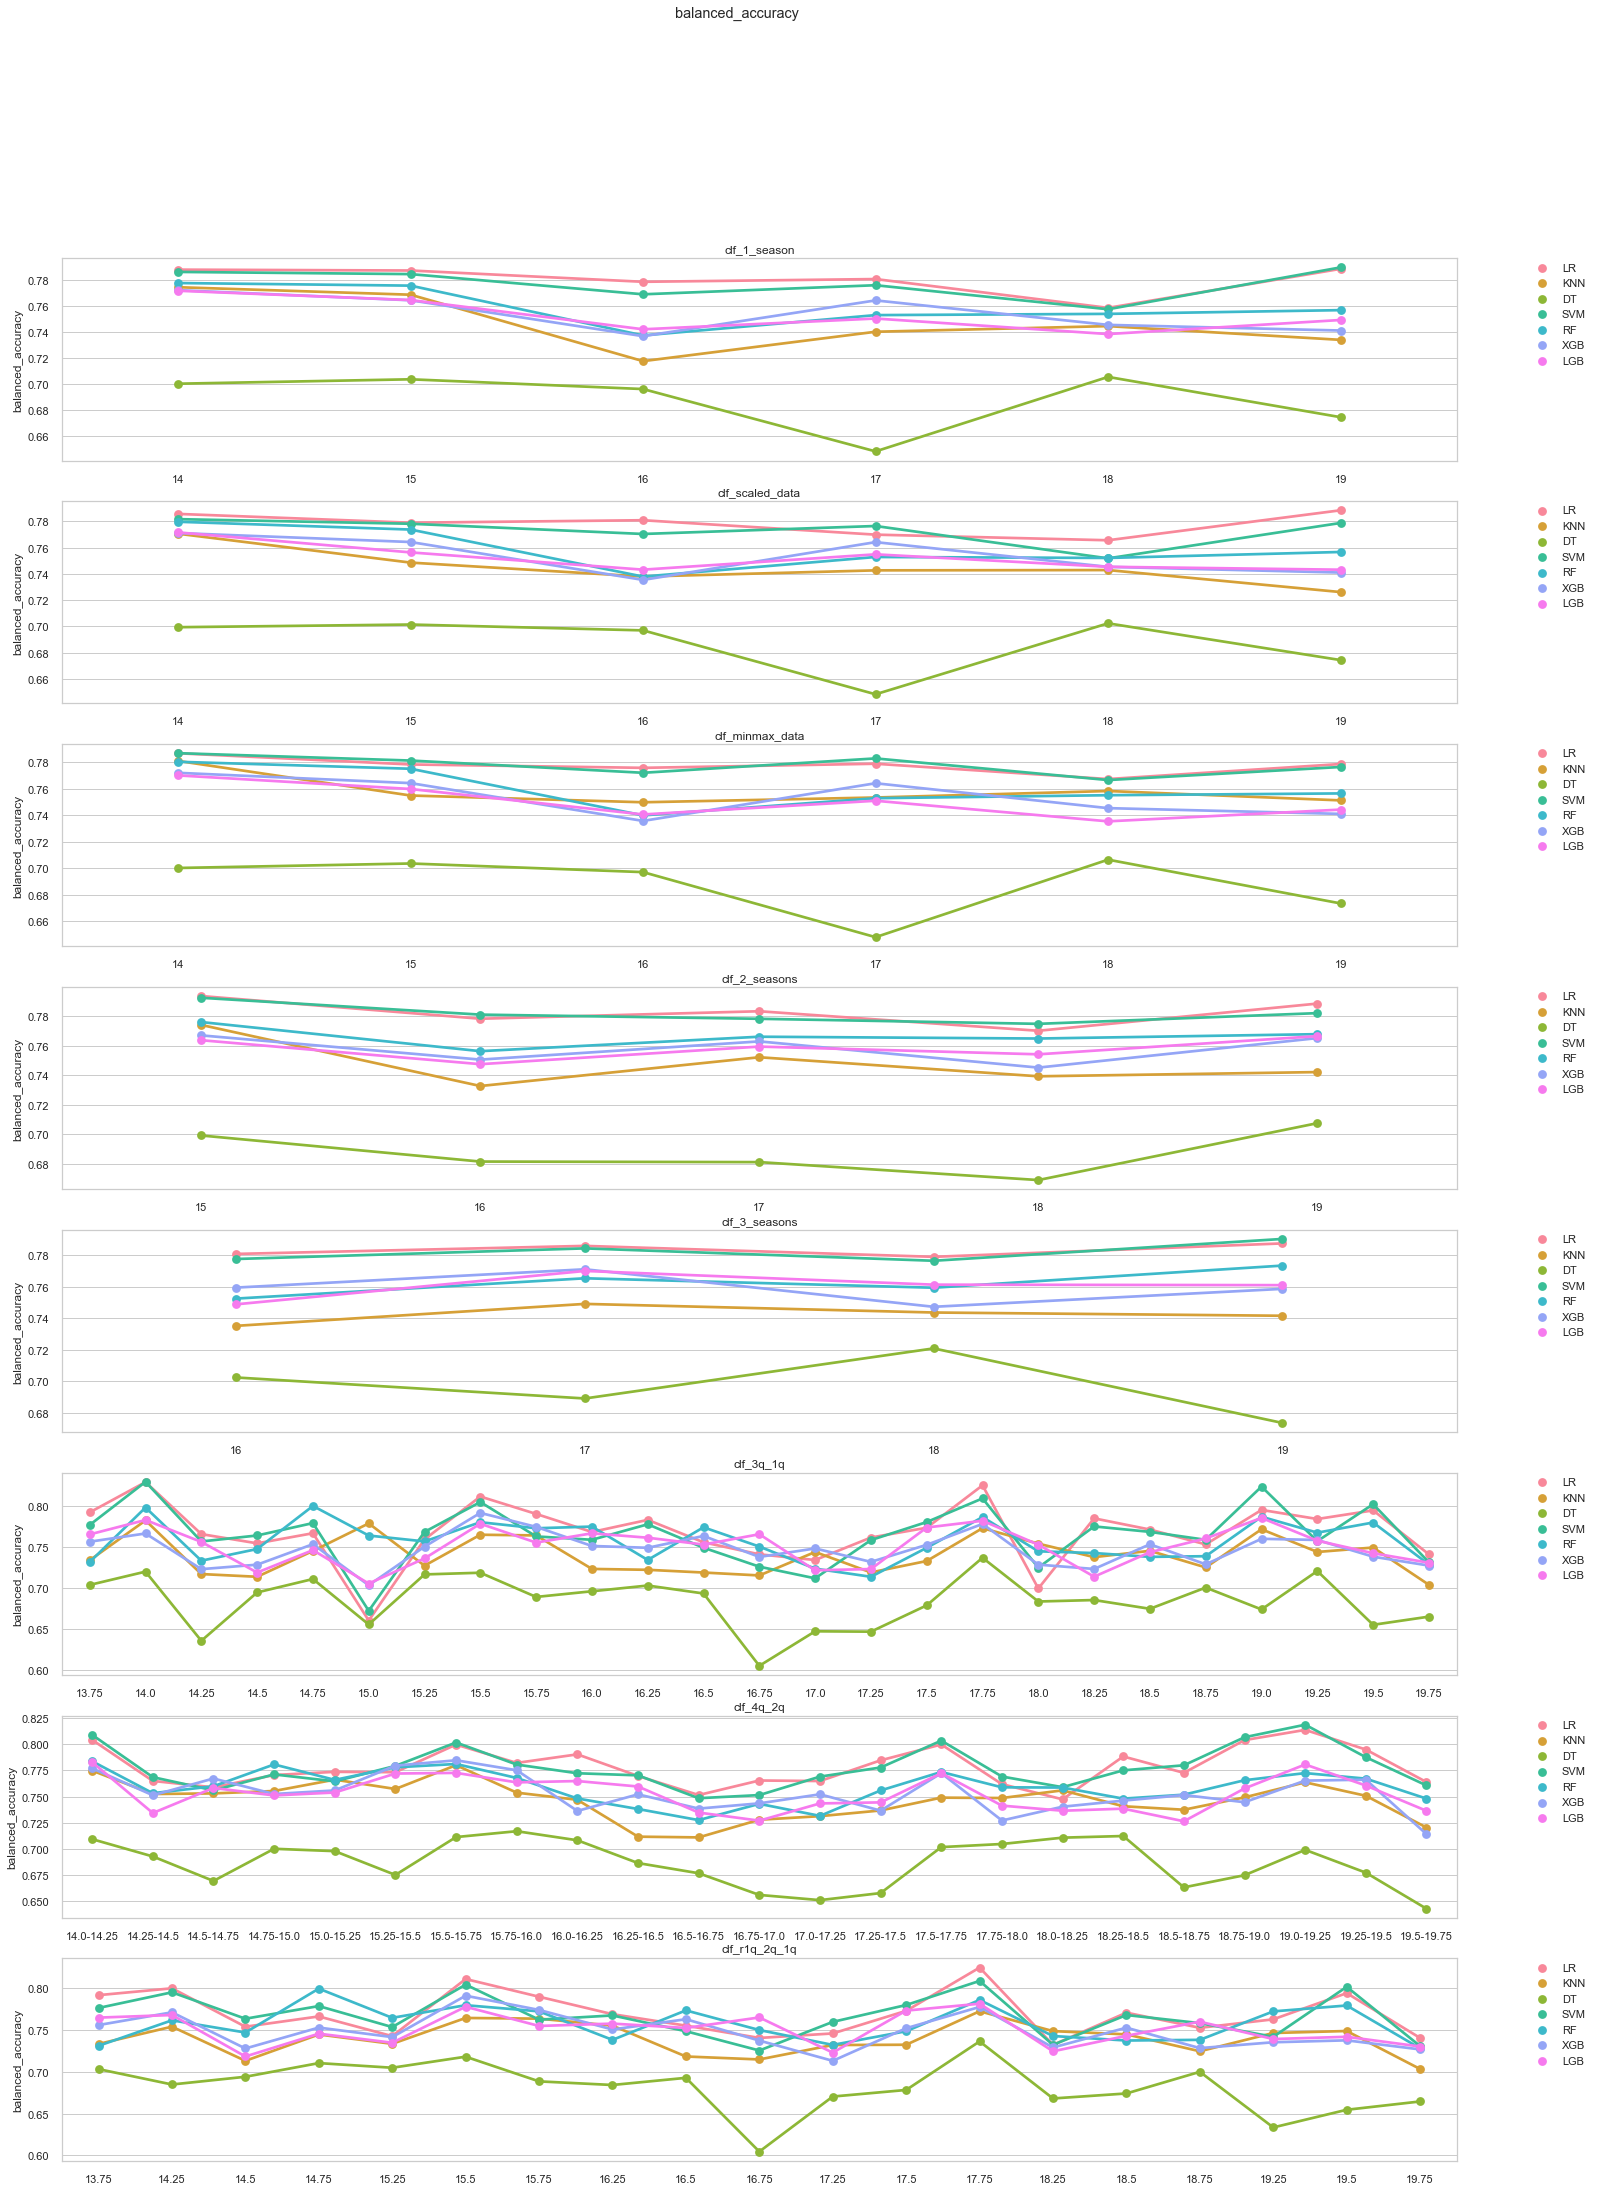

In [35]:
utils.plot_to_compare_experiments(
    results_total,
    metric="balanced_accuracy",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

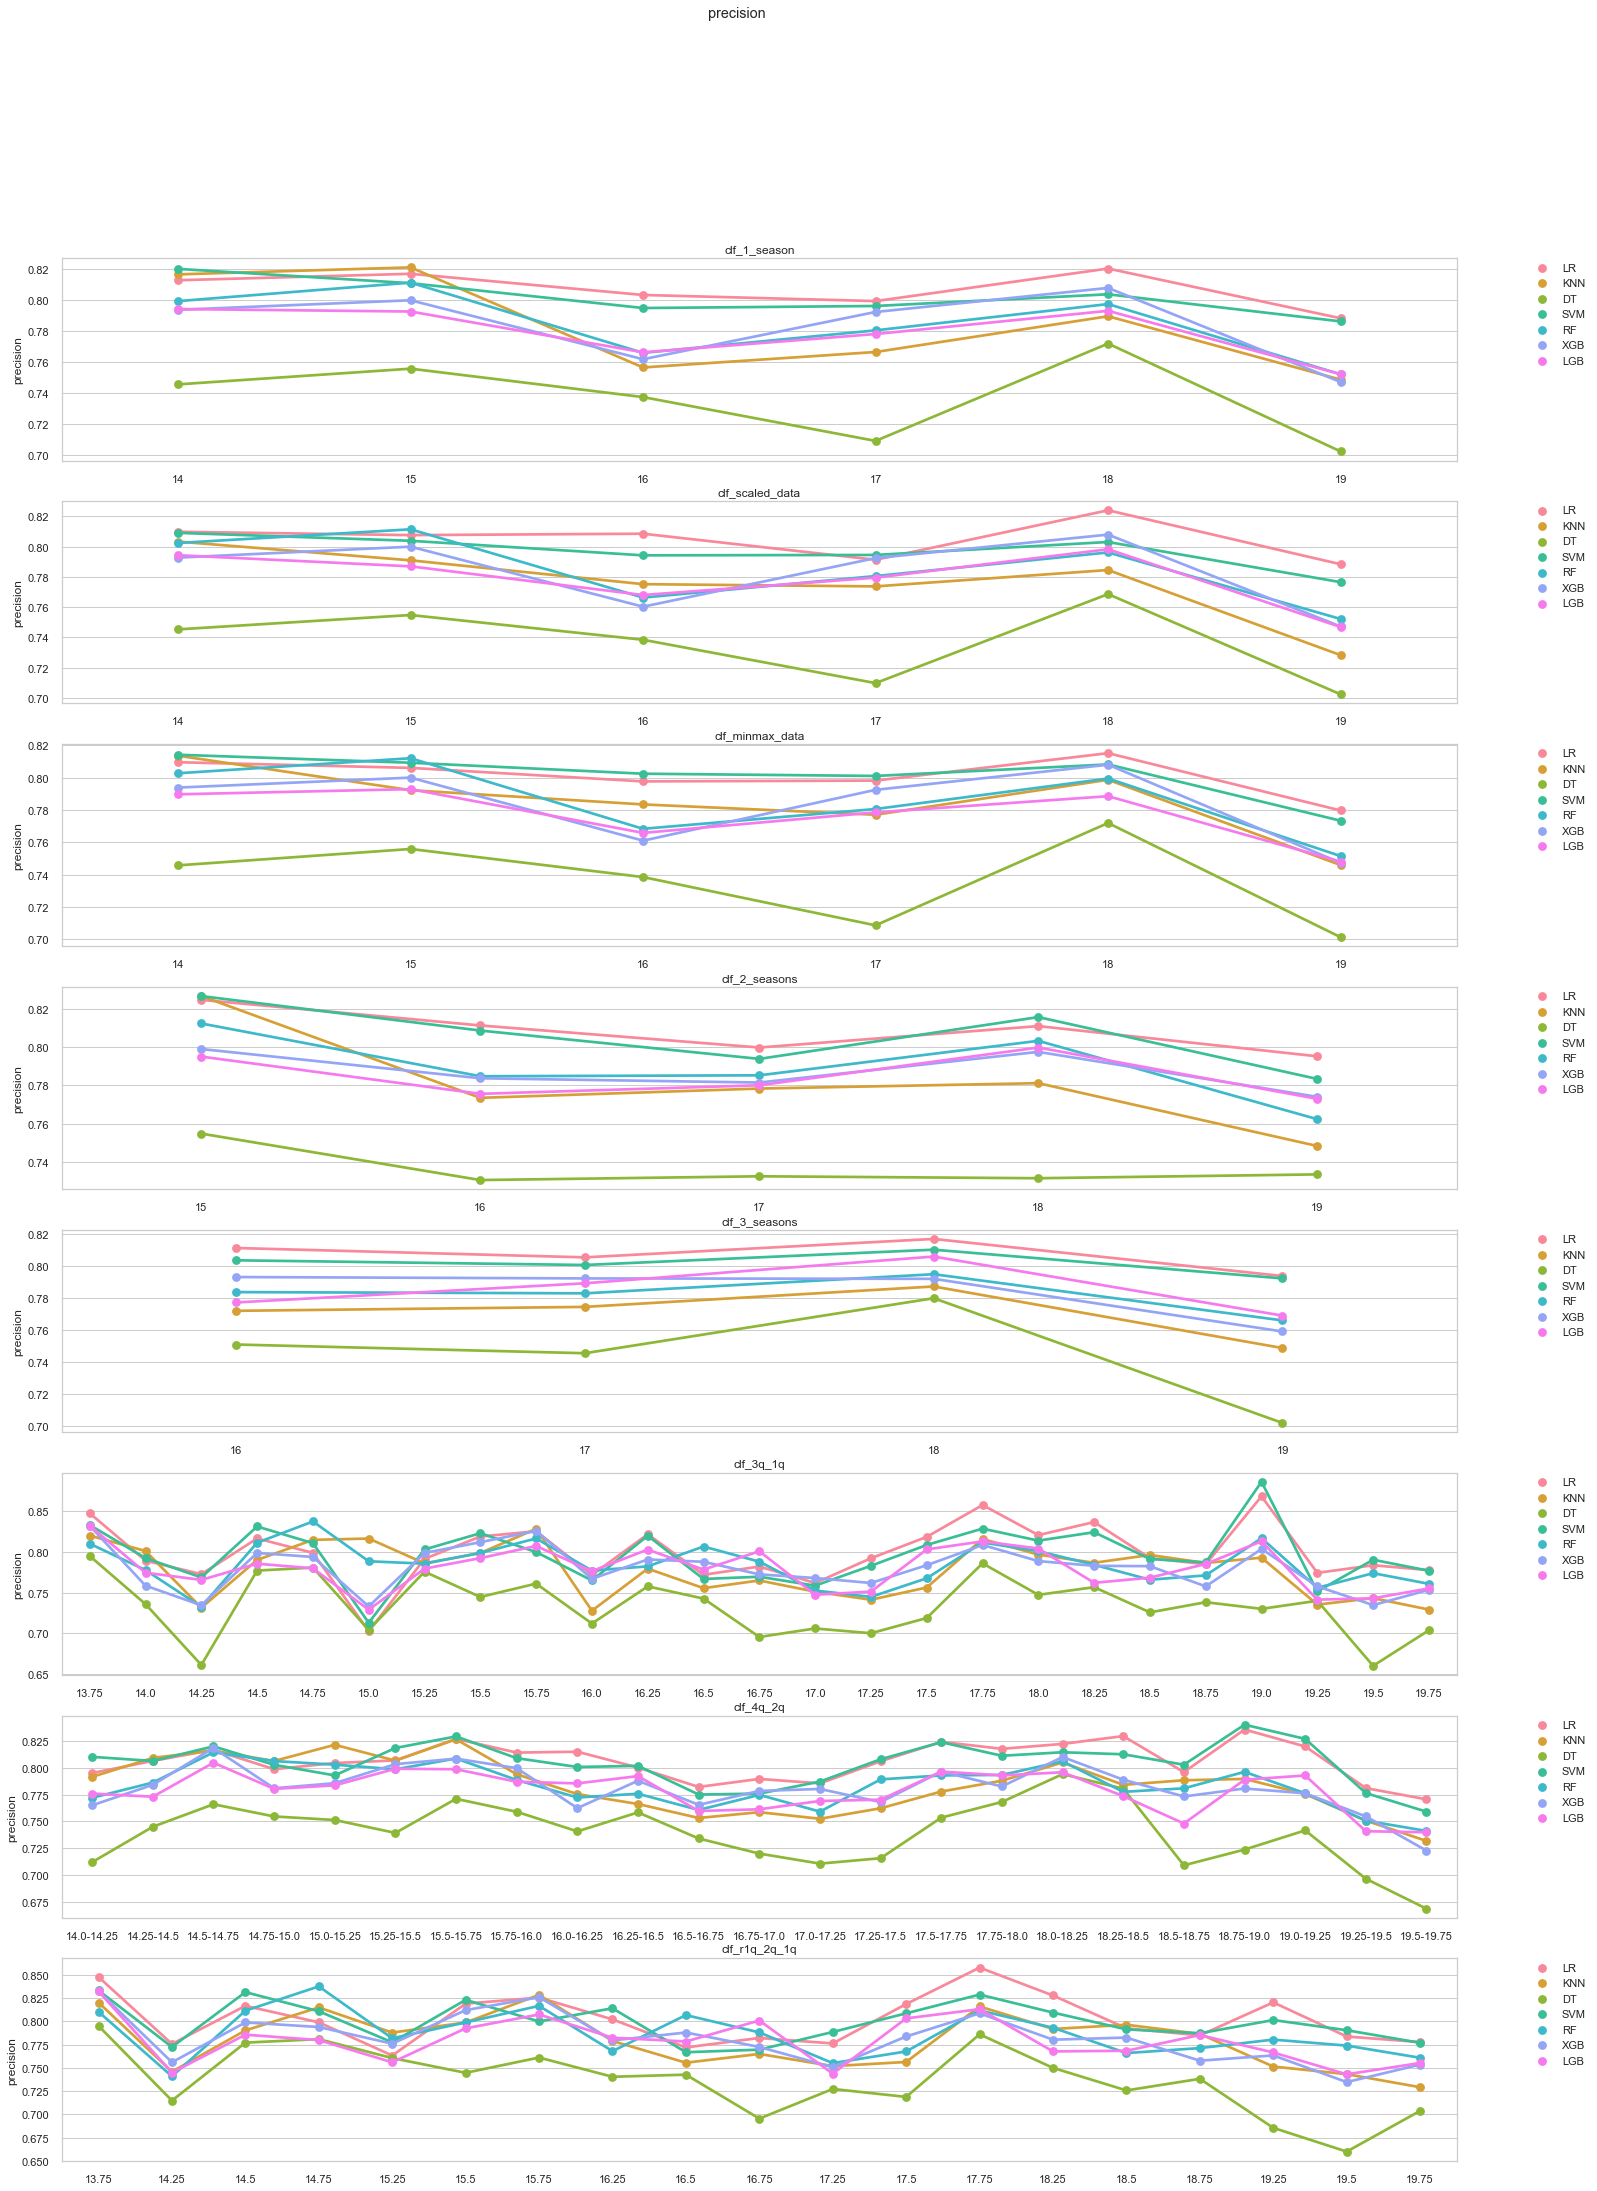

In [36]:
utils.plot_to_compare_experiments(
    results_total,
    metric="precision",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

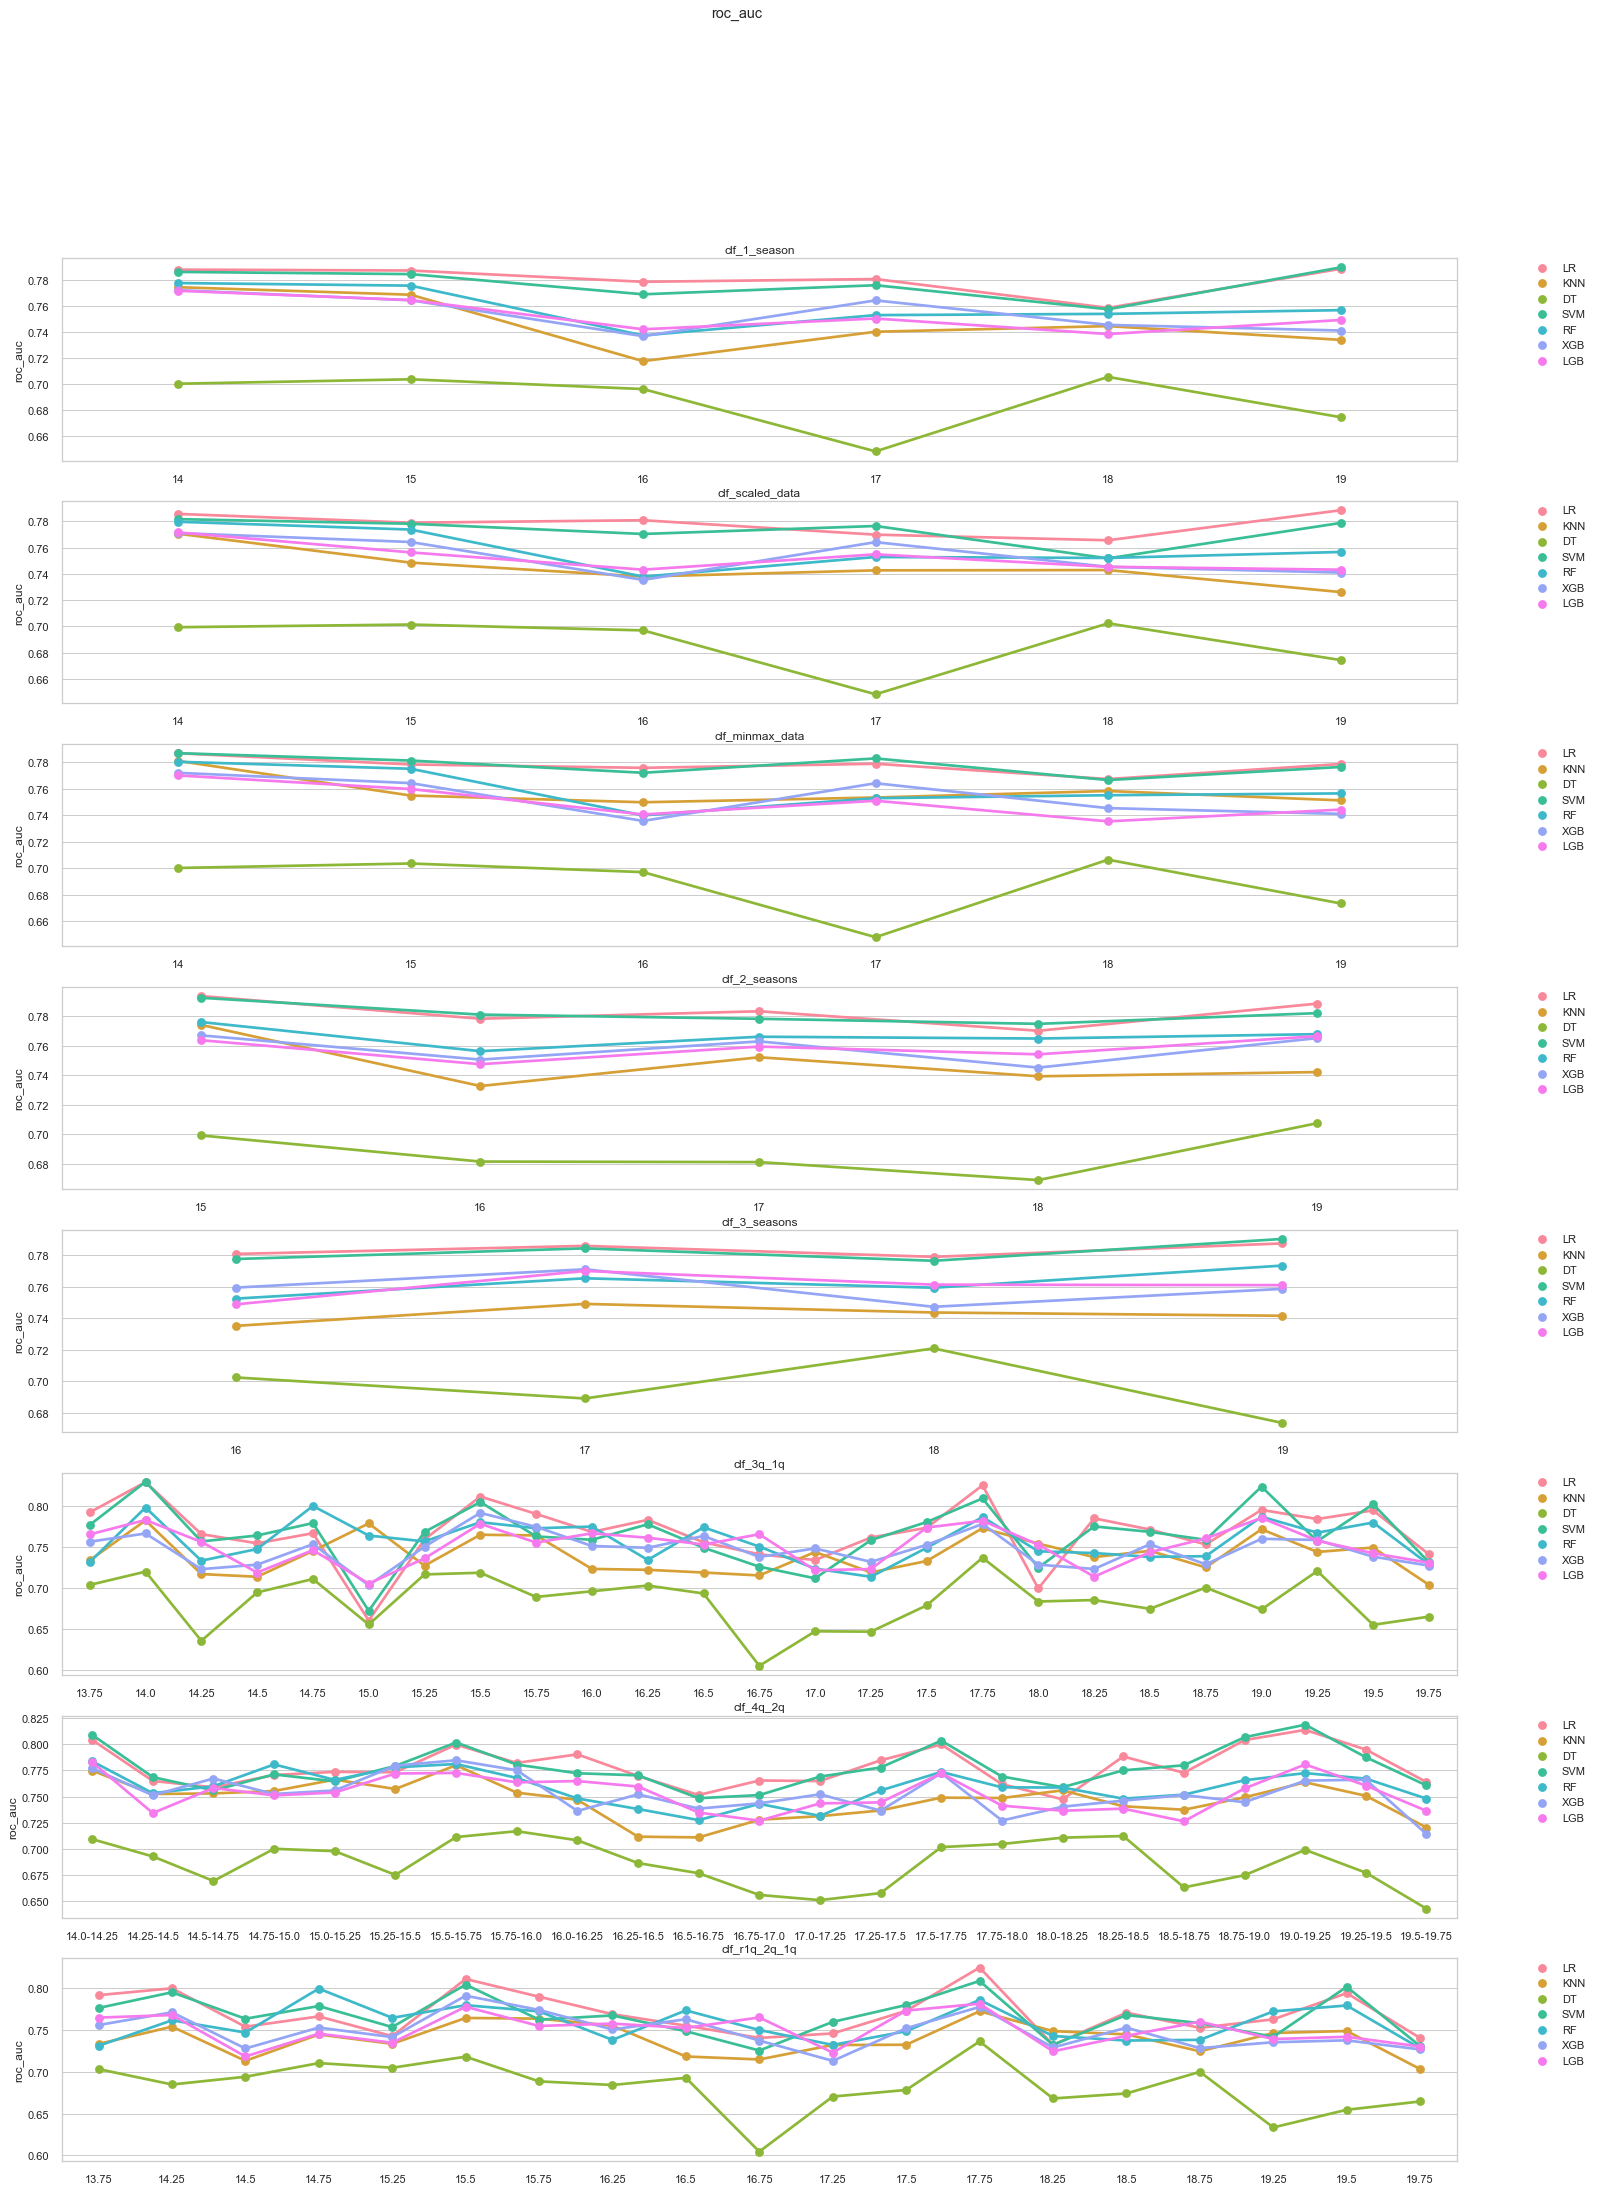

In [37]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)